# Library

In [1]:
import torch
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Logging

In [2]:
import logging

# Configure logging (example for `logging` module)
logging.basicConfig(
    level=logging.WARNING,  # Adjust as needed (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)


# References
- https://github.com/huggingface/transformers/issues/28778
- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb

Also helpful, but through google's research scenic repo
- https://github.com/google-research/scenic/issues/542

And also, nvidia implement
- https://github.com/NVIDIA-AI-IOT/nanoowl

# Data

- https://huggingface.co/datasets/cppe-5

## Dataset Summary

CPPE - 5 (Medical Personal Protective Equipment) is a new challenging dataset with the goal to allow the study of subordinate categorization of medical personal protective equipments, which is not possible with other popular data sets that focus on broad level categories.

Some features of this dataset are:

- high quality images and annotations (~4.6 bounding boxes per image)
- real-life images unlike any current such dataset
- majority of non-iconic images (allowing easy deployment to real-world environments)

In [3]:
from datasets import load_dataset
cppe5 = load_dataset("cppe-5")

categories = cppe5["train"].features["objects"].feature["category"].names
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

id2label
text_inputs =list(id2label.values())
print(text_inputs)


['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask']


One common problem with datasets for object detection is bounding boxes that “stretch” beyond the edge of the image. Such “runaway” bounding boxes can raise errors during training and should be addressed at this stage. There are a few examples with this issue in this dataset. To keep things simple in this guide, we remove these images from the data.

Also, lets limit to only 100 training images.

In [4]:
# remove image with bounding boxes outstreched
remove_idx = [590, 821, 822, 875, 876, 878, 879]
keep = [i for i in range(len(cppe5["train"])) if i not in remove_idx]

# limit to 100 images
keep = keep[0:100]
cppe5["train"] = cppe5["train"].select(keep)

illustrate one of the image

In [5]:
cppe5["train"][0]["objects"]

{'id': [114, 115, 116, 117],
 'area': [3796, 1596, 152768, 81002],
 'bbox': [[302.0, 109.0, 73.0, 52.0],
  [810.0, 100.0, 57.0, 28.0],
  [160.0, 31.0, 248.0, 616.0],
  [741.0, 68.0, 202.0, 401.0]],
 'category': [4, 4, 0, 0]}

In [6]:
cppe5["train"][1]["objects"]

{'id': [3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413],
 'area': [17780,
  17500,
  11656,
  13320,
  1750,
  11136,
  10283,
  18300,
  267526,
  72165,
  14760],
 'bbox': [[182.0, 492.0, 140.0, 127.0],
  [514.0, 483.0, 175.0, 100.0],
  [1042.0, 483.0, 124.0, 94.0],
  [463.0, 811.0, 148.0, 90.0],
  [287.0, 905.0, 70.0, 25.0],
  [344.0, 908.0, 116.0, 96.0],
  [702.0, 742.0, 113.0, 91.0],
  [798.0, 761.0, 150.0, 122.0],
  [1.0, 512.0, 394.0, 679.0],
  [907.0, 515.0, 283.0, 255.0],
  [955.0, 424.0, 180.0, 82.0]],
 'category': [4, 4, 4, 2, 2, 2, 2, 2, 0, 0, 3]}

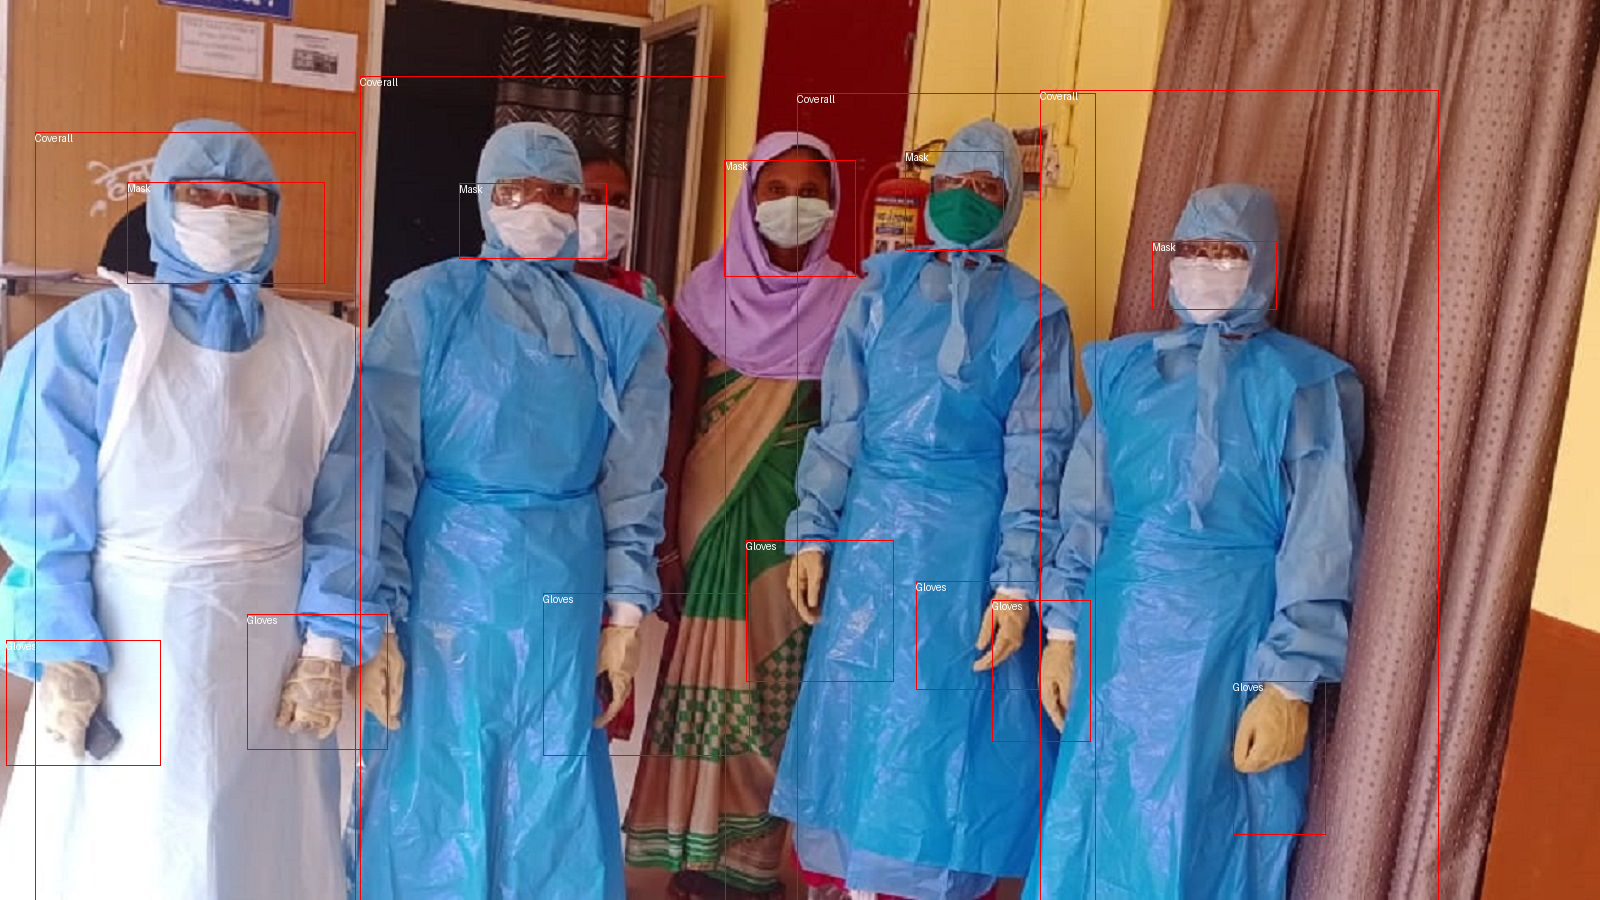

In [7]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][10]["image"]
annotations = cppe5["train"][10]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

# Model & Processor

In [8]:
from transformers import AutoImageProcessor
from transformers import AutoProcessor

# using image processor from detr
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

checkpoint = "google/owlvit-base-patch32"
processor = AutoProcessor.from_pretrained(checkpoint)

from transformers import AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
model.to(device)

print("loaded!")

# other better checkpoints, but would run out of memory with current T4 instance for fine-tuning, could be use for inference
# google/owlv2-base-patch16
# google/owlv2-large-patch14-finetuned
# google/owlv2-base-patch16-ensemble
# while with significant better performance, would run into OOM (Out of memory)

loaded!


## Testing raw owl-vit model on image data
- via pipeline

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


[{'score': 0.09769091755151749, 'label': 'Coverall', 'box': {'xmin': 325, 'ymin': 228, 'xmax': 682, 'ymax': 901}}, {'score': 0.08477938175201416, 'label': 'Coverall', 'box': {'xmin': -4, 'ymin': 249, 'xmax': 379, 'ymax': 899}}, {'score': 0.08333301544189453, 'label': 'Coverall', 'box': {'xmin': 766, 'ymin': 229, 'xmax': 1098, 'ymax': 897}}, {'score': 0.07367358356714249, 'label': 'Coverall', 'box': {'xmin': 1000, 'ymin': 298, 'xmax': 1376, 'ymax': 897}}, {'score': 0.0650748610496521, 'label': 'mask', 'box': {'xmin': 1166, 'ymin': 240, 'xmax': 1259, 'ymax': 310}}, {'score': 0.06061863154172897, 'label': 'Coverall', 'box': {'xmin': 0, 'ymin': 122, 'xmax': 376, 'ymax': 895}}, {'score': 0.05197671055793762, 'label': 'Coverall', 'box': {'xmin': -3, 'ymin': 262, 'xmax': 364, 'ymax': 714}}, {'score': 0.051861993968486786, 'label': 'glove', 'box': {'xmin': 1230, 'ymin': 683, 'xmax': 1316, 'ymax': 769}}]


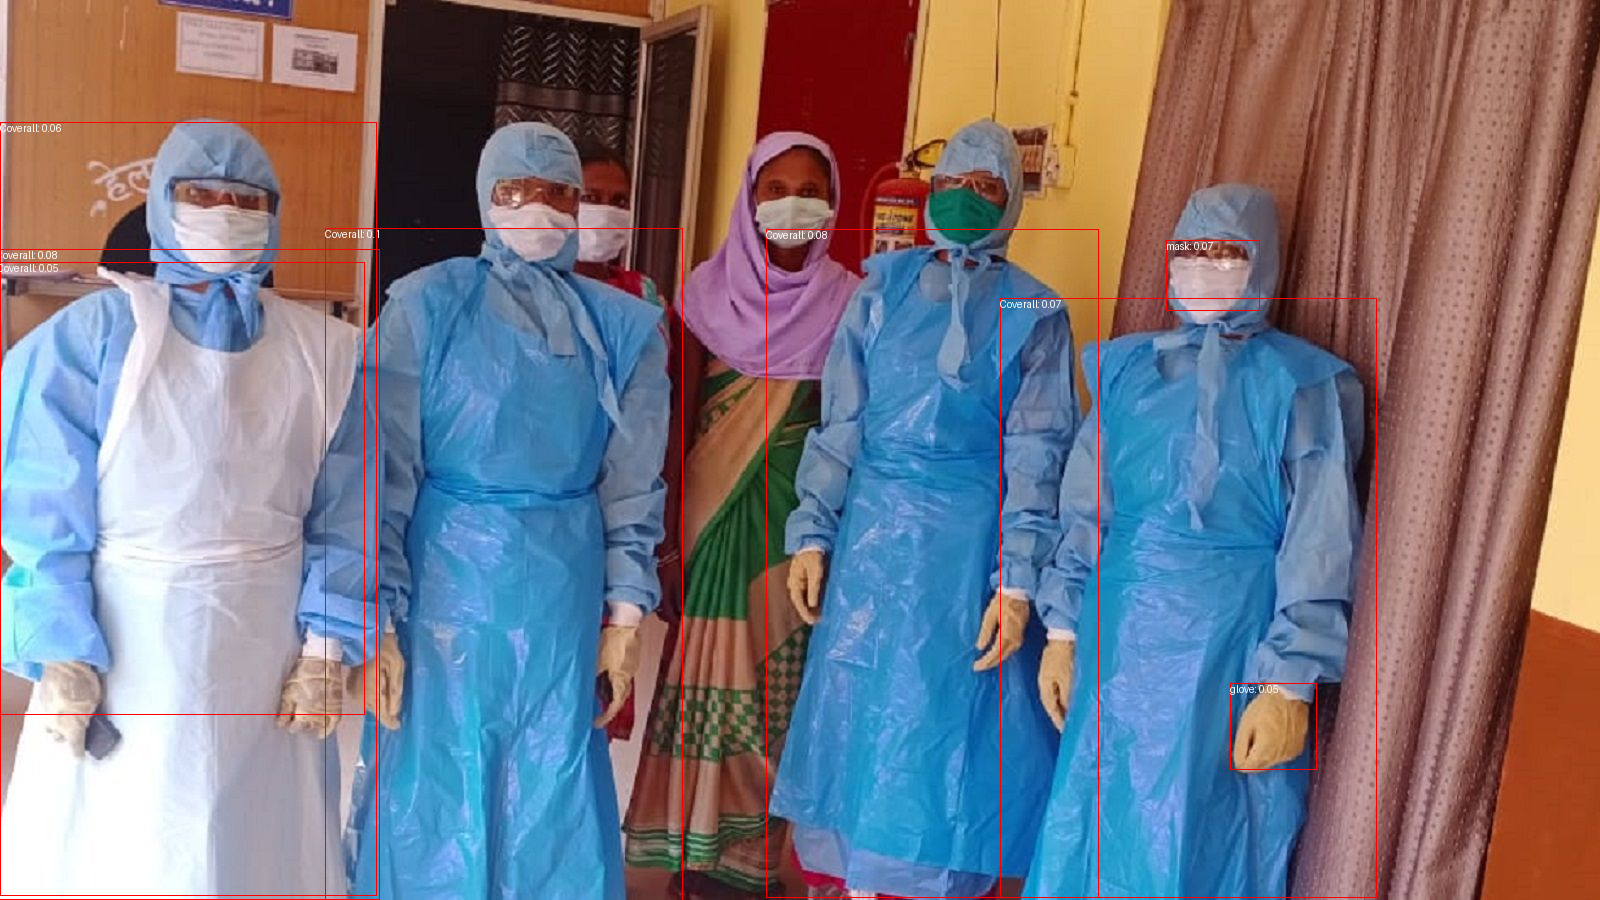

In [9]:
from transformers import pipeline

detector = pipeline(model=checkpoint, task="zero-shot-object-detection") #checkpoint

predictions = detector(
    image,
    candidate_labels=["Coverall", "Face_Shield", "mask", "glove"], 
    threshold=0.01,
    top_k=8
)
print(predictions)

from PIL import ImageDraw

image = cppe5["train"][10]["image"]
draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image

# Helper 
- prestransform the images and also setup the datasets

In [10]:
import albumentations
import numpy as np

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)


def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    transformed_data = []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])
        transformed_data.append(processor(text=text_inputs, images=image, return_tensors="pt"))

    
    return {"transformed_data":transformed_data}

# transforming a batch
def transform_aug_ann_labels(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

#applying to the datasets
transform_1 = cppe5["train"].with_transform(transform_aug_ann)
transform_2 = cppe5["train"].with_transform(transform_aug_ann_labels)

transform_1v = cppe5["test"].with_transform(transform_aug_ann)
transform_2v = cppe5["test"].with_transform(transform_aug_ann_labels)

## Encoding the data into Dataset

In [11]:
import pandas as pd
from datasets import Dataset

data = []
for i in range(len(transform_1)):
    dict_ = {}
    dict_["input_ids"] = transform_1[i]["transformed_data"]["input_ids"]
    dict_["attention_mask"] = transform_1[i]["transformed_data"]["attention_mask"]
    dict_["pixel_values"] = transform_1[i]["transformed_data"]["pixel_values"][0]
    dict_["labels"] = transform_2[i]["labels"]
    data.append(dict_)

# Preprocessed Training Data
train_dataset = Dataset.from_list(data)
train_dataset.features

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'input_ids': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None),
 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'labels': {'area': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
  'boxes': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None),
  'class_labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'image_id': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'iscrowd': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'orig_size': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'size': Sequence(feature=Value(dtype='int

In [12]:
data = []
for i in range(len(transform_1v)):
    dict_ = {}
    dict_["input_ids"] = transform_1v[i]["transformed_data"]["input_ids"]
    dict_["attention_mask"] = transform_1v[i]["transformed_data"]["attention_mask"]
    dict_["pixel_values"] = transform_1v[i]["transformed_data"]["pixel_values"][0]
    dict_["labels"] = transform_2v[i]["labels"]
    data.append(dict_)

# Preprocessed Training Data
test_dataset = Dataset.from_list(data)
test_dataset.features

{'input_ids': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None),
 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'labels': {'area': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
  'boxes': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None),
  'class_labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'image_id': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'iscrowd': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'orig_size': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'size': Sequence(feature=Value(dtype='int

## Detection

In [13]:
# Using Detr-Loss calculation https://github.com/facebookresearch/detr/blob/main/models/matcher.py
# https://www.kaggle.com/code/bibhasmondal96/detr-from-scratch
class BoxUtils(object):
    @staticmethod
    def box_cxcywh_to_xyxy(x):
        x_c, y_c, w, h = x.unbind(-1)
        b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
             (x_c + 0.5 * w), (y_c + 0.5 * h)]
        return torch.stack(b, dim=-1)

    @staticmethod
    def box_xyxy_to_cxcywh(x):
        x0, y0, x1, y1 = x.unbind(-1)
        b = [(x0 + x1) / 2, (y0 + y1) / 2,
             (x1 - x0), (y1 - y0)]
        return torch.stack(b, dim=-1)

    @staticmethod
    def rescale_bboxes(out_bbox, size):
        img_h, img_w = size
        b = BoxUtils.box_cxcywh_to_xyxy(out_bbox)
        b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
        return b

    @staticmethod
    def box_area(boxes):
        """
        Computes the area of a set of bounding boxes, which are specified by its
        (x1, y1, x2, y2) coordinates.
        Arguments:
            boxes (Tensor[N, 4]): boxes for which the area will be computed. They
                are expected to be in (x1, y1, x2, y2) format
        Returns:
            area (Tensor[N]): area for each box
        """
        return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        
    @staticmethod
    # modified from torchvision to also return the union
    def box_iou(boxes1, boxes2):
        area1 = BoxUtils.box_area(boxes1)
        area2 = BoxUtils.box_area(boxes2)

        lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
        rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

        wh = (rb - lt).clamp(min=0)  # [N,M,2]
        inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

        union = area1[:, None] + area2 - inter

        iou = inter / union
        return iou, union

    @staticmethod
    def generalized_box_iou(boxes1, boxes2):
        """
        Generalized IoU from https://giou.stanford.edu/
        The boxes should be in [x0, y0, x1, y1] format
        Returns a [N, M] pairwise matrix, where N = len(boxes1)
        and M = len(boxes2)
        """
        # degenerate boxes gives inf / nan results
        # so do an early check
        assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
        assert (boxes2[:, 2:] >= boxes2[:, :2]).all()
        iou, union = BoxUtils.box_iou(boxes1, boxes2)

        lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
        rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

        wh = (rb - lt).clamp(min=0)  # [N,M,2]
        area = wh[:, :, 0] * wh[:, :, 1]

        return iou - (area - union) / area

# Custom trainer for hugging face transformer

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.optimize import linear_sum_assignment

class HungarianMatcher(nn.Module):
    """This class computes an assignment between the targets and the predictions of the network
    For efficiency reasons, the targets don't include the no_object. Because of this, in general,
    there are more predictions than targets. In this case, we do a 1-to-1 matching of the best predictions,
    while the others are un-matched (and thus treated as non-objects).
    """

    def __init__(self, cost_class: float = 1, cost_bbox: float = 1, cost_giou: float = 1):
        """Creates the matcher
        Params:
            cost_class: This is the relative weight of the classification error in the matching cost
            cost_bbox: This is the relative weight of the L1 error of the bounding box coordinates in the matching cost
            cost_giou: This is the relative weight of the giou loss of the bounding box in the matching cost
        """
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        assert cost_class != 0 or cost_bbox != 0 or cost_giou != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        """ Performs the matching
        Params:
            outputs: This is a dict that contains at least these entries:
                 "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
                 "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates
            targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:
                 "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth
                           objects in the target) containing the class labels
                 "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates
        Returns:
            A list of size batch_size, containing tuples of (index_i, index_j) where:
                - index_i is the indices of the selected predictions (in order)
                - index_j is the indices of the corresponding selected targets (in order)
            For each batch element, it holds:
                len(index_i) = len(index_j) = min(num_queries, num_target_boxes)
        """
        logging.info(f"{outputs.keys()=}")
        bs, num_queries = outputs["logits"].shape[:2]

        # We flatten to compute the cost matrices in a batch
        out_prob = outputs["logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["class_labels"] for v in targets])
        logging.info(f"forward - {tgt_ids}")
        tgt_ids = tgt_ids.int()
        logging.info(f"forward - {tgt_ids}")


        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        cost_class = -out_prob[:, tgt_ids]

        # Compute the L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

        # Compute the giou cost betwen boxes
        cost_giou = -BoxUtils.generalized_box_iou(
            BoxUtils.box_cxcywh_to_xyxy(out_bbox),
            BoxUtils.box_cxcywh_to_xyxy(tgt_bbox)
        )

        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

class SetCriterion(nn.Module):
    """ This class computes the loss for DETR.
    The process happens in two steps:
        1) we compute hungarian assignment between ground truth boxes and the outputs of the model
        2) we supervise each pair of matched ground-truth / prediction (supervise class and box)
    """
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        """ Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            matcher: module able to compute a matching between targets and proposals
            weight_dict: dict containing as key the names of the losses and as values their relative weight.
            eos_coef: relative classification weight applied to the no-object category
            losses: list of all the losses to be applied. See get_loss for list of available losses.
        """
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        logging.info(f"loss_labels - {outputs.keys()}")
        assert 'logits' in outputs
        src_logits = outputs['logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["class_labels"][J] for t, (_, J) in zip(targets, indices)]).to(torch.int64)
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device).to(torch.int64)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}
        return losses

    @torch.no_grad()
    def loss_cardinality(self, outputs, targets, indices, num_boxes):
        """ Compute the cardinality error, ie the absolute error in the number of predicted non-empty boxes
        This is not really a loss, it is intended for logging purposes only. It doesn't propagate gradients
        """
        pred_logits = outputs['logits']
        device = pred_logits.device
        tgt_lengths = torch.as_tensor([len(v["class_labels"]) for v in targets], device=device)
        # Count the number of predictions that are NOT "no-object" (which is the last class)
        card_pred = (pred_logits.argmax(-1) != pred_logits.shape[-1] - 1).sum(1)
        card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
        losses = {'cardinality_error': card_err}
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
           targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
           The target boxes are expected in format (center_x, center_y, w, h), normalized by the image size.
        """
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(BoxUtils.generalized_box_iou(
            BoxUtils.box_cxcywh_to_xyxy(src_boxes),
            BoxUtils.box_cxcywh_to_xyxy(target_boxes))
        )
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'cardinality': self.loss_cardinality,
            'boxes': self.loss_boxes,
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):
        """ This performs the loss computation.
        Parameters:
             outputs: dict of tensors, see the output specification of the model for the format
             targets: list of dicts, such that len(targets) == batch_size.
                      The expected keys in each dict depends on the losses applied, see each loss' doc
        """
        logging.info(f"{type(outputs)=}")
        logging.info(f"{type(targets)=}")
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}

        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["class_labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))
        return losses
    
def collate_fn(batch):
    input_ids = torch.Tensor([item["input_ids"] for item in batch]).int()
    input_ids = input_ids.to(device)
    attention_mask = torch.Tensor([item["attention_mask"] for item in batch]).int()
    attention_mask = attention_mask.to(device)
    pixel_values = torch.Tensor([item["pixel_values"] for item in batch])
    pixel_values = pixel_values.to(device)
    labels = []
    for item in batch:
        for (key, value) in item["labels"].items():
            item["labels"][key] = torch.Tensor(value).to(device)
        labels.append(item["labels"])
     
    batch = {}
    batch["input_ids"] = input_ids
    batch["attention_mask"] = attention_mask
    batch["pixel_values"] = pixel_values
    batch["labels"] = labels
    return batch

# Putting it together

To compute the custom loss we defined, we need to create a custom Trainer that inherits from the Hugging Face Trainer class. This will allow us to override the compute_loss method and implement our custom loss calculation.

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="owlvit-base-patch32_FT_cppe5",
    per_device_train_batch_size=1,
    num_train_epochs=20,
    fp16=True,
    save_steps=400,
    logging_steps=200,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    gradient_accumulation_steps=1,
    push_to_hub=False,
    report_to='none', # disable wandb
)

# custom loss
def custom_loss(logits, labels):
    num_classes = 4
    matcher = HungarianMatcher(cost_class = 1, cost_bbox = 5, cost_giou = 2)
    weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
    losses = ['labels', 'boxes', 'cardinality']
    criterion = SetCriterion(num_classes, matcher=matcher, weight_dict=weight_dict, eos_coef=0.1, losses=losses)
    criterion.to(device)
    loss = criterion(logits, labels)
    return loss

# subclass trainer
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")

        inputs["input_ids"] = inputs["input_ids"][0]
        inputs["attention_mask"] = inputs["attention_mask"][0]
        outputs = model(**inputs, return_dict=True)
        loss = custom_loss(outputs, labels)
        loss_ce = loss['loss_ce'].cpu().item()
        loss_bbox = loss['loss_bbox'].cpu().item()
        loss_giou = loss['loss_giou'].cpu().item()
        cardinality_error = loss['cardinality_error'].cpu().item()
        # print(
        #     f"loss_ce={loss_ce:.2f}",
        #     f"loss_bbox={loss_bbox:.2f}",
        #     f"loss_giou={loss_giou:.2f}",
        #     f"cardinality_error={cardinality_error:.2f}",
        #     sep="\t")
        loss = sum(loss.values())[0] #add
        return (loss, outputs) if return_outputs else loss

# use new trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
    tokenizer=processor,
 )
 
eval_dict = trainer.train()
# trainer would takes about 35mins with t4

In [16]:
model_path = "local/custom_owl_vit"
trainer.save_model(model_path)

# Inference

## fine-tuned model

[{'score': 0.5717632174491882, 'label': 'Coverall', 'box': {'xmin': 94, 'ymin': 6, 'xmax': 296, 'ymax': 503}}, {'score': 0.029728326946496964, 'label': 'glove', 'box': {'xmin': 237, 'ymin': 294, 'xmax': 270, 'ymax': 343}}, {'score': 0.025738930329680443, 'label': 'glove', 'box': {'xmin': 106, 'ymin': 305, 'xmax': 137, 'ymax': 359}}]


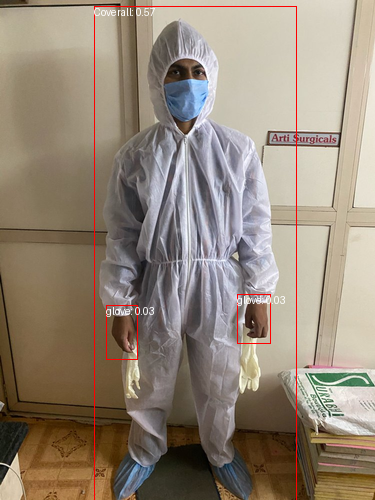

In [21]:
from PIL import ImageDraw
from transformers import pipeline

model_path = "local/custom_owl_vit"
detector = pipeline(model=model_path, task="zero-shot-object-detection") #model_path

image = cppe5["train"][16]["image"]

predictions = detector(
    image,
    candidate_labels=["Coverall", "Face_Shield", "glove"],
    threshold=0.01,
    top_k=8
)
print(predictions)

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image

## raw model

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


[{'score': 0.0843648910522461, 'label': 'Coverall', 'box': {'xmin': 96, 'ymin': 57, 'xmax': 277, 'ymax': 483}}, {'score': 0.0473240502178669, 'label': 'Coverall', 'box': {'xmin': 98, 'ymin': 17, 'xmax': 277, 'ymax': 501}}, {'score': 0.04314463585615158, 'label': 'Face_Shield', 'box': {'xmin': 162, 'ymin': 60, 'xmax': 208, 'ymax': 119}}, {'score': 0.03936583921313286, 'label': 'glove', 'box': {'xmin': 238, 'ymin': 326, 'xmax': 262, 'ymax': 393}}, {'score': 0.03772973641753197, 'label': 'Coverall', 'box': {'xmin': 102, 'ymin': 95, 'xmax': 279, 'ymax': 355}}, {'score': 0.0290459506213665, 'label': 'glove', 'box': {'xmin': 121, 'ymin': 344, 'xmax': 141, 'ymax': 398}}, {'score': 0.023682883009314537, 'label': 'Coverall', 'box': {'xmin': 99, 'ymin': 92, 'xmax': 280, 'ymax': 366}}, {'score': 0.017103200778365135, 'label': 'Coverall', 'box': {'xmin': 98, 'ymin': 100, 'xmax': 275, 'ymax': 348}}]


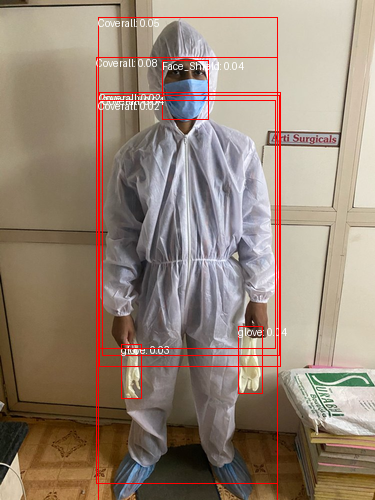

In [22]:
model_path = "google/owlvit-base-patch32"
detector = pipeline(model=model_path, task="zero-shot-object-detection") #model_path

image = cppe5["train"][16]["image"]

predictions = detector(
    image,
    candidate_labels=["Coverall", "Face_Shield", "glove",],
    threshold=0.01,
    top_k=8
)
print(predictions)

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image